## Step 1: Setup in Google Colab
Install PySpark and create a Spark session.


In [2]:
!pip install pyspark

from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Retail-Capstone").getOrCreate()
sc = spark.sparkContext


## Step 2: Prepare Data
We create sample datasets for **Customers, Products, and Orders**.


In [3]:
# Customers Data
customers_data = [
    (1, "Rahul Sharma", "Bangalore", 28),
    (2, "Priya Singh", "Delhi", 32),
    (3, "Aman Kumar", "Hyderabad", 25),
    (4, "Sneha Reddy", "Chennai", 35),
    (5, "Arjun Mehta", "Mumbai", 30),
    (6, "Divya Nair", "Delhi", 29)
]
customers_cols = ["customer_id", "name", "city", "age"]
customers_df = spark.createDataFrame(customers_data, customers_cols)

# Products Data
products_data = [
    (101, "Laptop", "Electronics", 55000),
    (102, "Mobile", "Electronics", 25000),
    (103, "Headphones", "Electronics", 3000),
    (104, "Chair", "Furniture", 5000),
    (105, "Book", "Stationery", 700),
    (106, "Shoes", "Fashion", 2500)
]
products_cols = ["product_id", "product_name", "category", "price"]
products_df = spark.createDataFrame(products_data, products_cols)

# Orders Data
orders_data = [
    (1001, 1, 101, 1, "2024-01-10"),
    (1002, 2, 102, 2, "2024-01-12"),
    (1003, 1, 103, 3, "2024-02-05"),
    (1004, 3, 104, 1, "2024-02-08"),
    (1005, 5, 105, 5, "2024-03-01"),
    (1006, 6, 106, 2, "2024-03-15"),
    (1007, 7, 101, 1, "2024-03-20")  # Non-existent customer
]
orders_cols = ["order_id", "customer_id", "product_id", "quantity", "order_date"]
orders_df = spark.createDataFrame(orders_data, orders_cols)


## Part A – RDD Basics
We practice with PySpark RDDs:  
1. Numbers RDD – sum, max, min, avg  
2. Word count from a list of sentences


In [4]:
# 1. Numbers RDD
nums = sc.parallelize([10, 20, 30, 40, 50])
print("Sum:", nums.sum())
print("Max:", nums.max())
print("Min:", nums.min())
print("Avg:", nums.mean())

# 2. Word count
sentences = sc.parallelize(["spark is great", "spark is fast", "pyspark is powerful"])
words = sentences.flatMap(lambda x: x.split(" "))
word_count = words.map(lambda x: (x, 1)).reduceByKey(lambda a, b: a + b)
print(word_count.collect())


Sum: 150
Max: 50
Min: 10
Avg: 30.0
[('fast', 1), ('powerful', 1), ('spark', 2), ('is', 3), ('great', 1), ('pyspark', 1)]


## Part B – DataFrame Operations
Performing basic DataFrame queries:
- Show customers & cities  
- Customers older than 30  
- Distinct product categories  
- Top 3 expensive products


In [5]:
customers_df.select("name", "city").show()
customers_df.filter(customers_df.age > 30).show()
products_df.select("category").distinct().show()
products_df.orderBy(products_df.price.desc()).limit(3).show()


+------------+---------+
|        name|     city|
+------------+---------+
|Rahul Sharma|Bangalore|
| Priya Singh|    Delhi|
|  Aman Kumar|Hyderabad|
| Sneha Reddy|  Chennai|
| Arjun Mehta|   Mumbai|
|  Divya Nair|    Delhi|
+------------+---------+

+-----------+-----------+-------+---+
|customer_id|       name|   city|age|
+-----------+-----------+-------+---+
|          2|Priya Singh|  Delhi| 32|
|          4|Sneha Reddy|Chennai| 35|
+-----------+-----------+-------+---+

+-----------+
|   category|
+-----------+
|Electronics|
| Stationery|
|    Fashion|
|  Furniture|
+-----------+

+----------+------------+-----------+-----+
|product_id|product_name|   category|price|
+----------+------------+-----------+-----+
|       101|      Laptop|Electronics|55000|
|       102|      Mobile|Electronics|25000|
|       104|       Chair|  Furniture| 5000|
+----------+------------+-----------+-----+



## Part C – Aggregations
Group and aggregate data:
- Average age per city  
- Total revenue by product  
- Most popular product by quantity


In [6]:
from pyspark.sql.functions import avg, sum

customers_df.groupBy("city").agg(avg("age")).show()

orders_products = orders_df.join(products_df, "product_id")
orders_products.withColumn("revenue", orders_products.quantity * orders_products.price) \
    .groupBy("product_name").agg(sum("revenue")).show()

orders_df.groupBy("product_id").agg(sum("quantity").alias("total_qty")) \
    .orderBy("total_qty", ascending=False).show(1)


+---------+--------+
|     city|avg(age)|
+---------+--------+
|Bangalore|    28.0|
|    Delhi|    30.5|
|Hyderabad|    25.0|
|  Chennai|    35.0|
|   Mumbai|    30.0|
+---------+--------+

+------------+------------+
|product_name|sum(revenue)|
+------------+------------+
|       Chair|        5000|
|        Book|        3500|
|      Laptop|      110000|
|       Shoes|        5000|
|      Mobile|       50000|
|  Headphones|        9000|
+------------+------------+

+----------+---------+
|product_id|total_qty|
+----------+---------+
|       105|        5|
+----------+---------+
only showing top 1 row



## Part D – Joins
We join multiple DataFrames to get insights:
1. Customers with Orders  
2. Orders with Products  
3. Customers without Orders  
4. Products never ordered


In [7]:
customers_orders = customers_df.join(orders_df, "customer_id")
customers_orders.show()

orders_products = orders_df.join(products_df, "product_id")
orders_products.show()

customers_df.join(orders_df, "customer_id", "left_anti").show()
products_df.join(orders_df, "product_id", "left_anti").show()


+-----------+------------+---------+---+--------+----------+--------+----------+
|customer_id|        name|     city|age|order_id|product_id|quantity|order_date|
+-----------+------------+---------+---+--------+----------+--------+----------+
|          1|Rahul Sharma|Bangalore| 28|    1001|       101|       1|2024-01-10|
|          1|Rahul Sharma|Bangalore| 28|    1003|       103|       3|2024-02-05|
|          2| Priya Singh|    Delhi| 32|    1002|       102|       2|2024-01-12|
|          3|  Aman Kumar|Hyderabad| 25|    1004|       104|       1|2024-02-08|
|          5| Arjun Mehta|   Mumbai| 30|    1005|       105|       5|2024-03-01|
|          6|  Divya Nair|    Delhi| 29|    1006|       106|       2|2024-03-15|
+-----------+------------+---------+---+--------+----------+--------+----------+

+----------+--------+-----------+--------+----------+------------+-----------+-----+
|product_id|order_id|customer_id|quantity|order_date|product_name|   category|price|
+----------+-------

## Part E – SQL Queries
We register DataFrames as SQL views and run queries:
- Top 2 cities by revenue  
- Customers spending > 50,000  
- Best-selling category by revenue


In [8]:
customers_df.createOrReplaceTempView("customers")
products_df.createOrReplaceTempView("products")
orders_df.createOrReplaceTempView("orders")

spark.sql("""
SELECT c.city, SUM(o.quantity * p.price) as total_revenue
FROM customers c
JOIN orders o ON c.customer_id = o.customer_id
JOIN products p ON o.product_id = p.product_id
GROUP BY c.city
ORDER BY total_revenue DESC
LIMIT 2
""").show()

spark.sql("""
SELECT c.name, SUM(o.quantity * p.price) as total_spent
FROM customers c
JOIN orders o ON c.customer_id = o.customer_id
JOIN products p ON o.product_id = p.product_id
GROUP BY c.name
HAVING total_spent > 50000
""").show()

spark.sql("""
SELECT p.category, SUM(o.quantity * p.price) as total_revenue
FROM products p
JOIN orders o ON p.product_id = o.product_id
GROUP BY p.category
ORDER BY total_revenue DESC
LIMIT 1
""").show()


+---------+-------------+
|     city|total_revenue|
+---------+-------------+
|Bangalore|        64000|
|    Delhi|        55000|
+---------+-------------+

+------------+-----------+
|        name|total_spent|
+------------+-----------+
|Rahul Sharma|      64000|
+------------+-----------+

+-----------+-------------+
|   category|total_revenue|
+-----------+-------------+
|Electronics|       169000|
+-----------+-------------+



## Part F – File I/O
We save and reload data:  
- Orders as CSV  
- Products as JSON


In [9]:
orders_df.write.csv("/content/orders_csv", header=True, mode="overwrite")
orders_csv = spark.read.csv("/content/orders_csv", header=True, inferSchema=True)

products_df.write.json("/content/products_json", mode="overwrite")
products_json = spark.read.json("/content/products_json")


## Part G – Visualization
Convert PySpark DataFrames to Pandas and plot:  
1. Revenue by Category (Bar chart)  
2. Orders per Month (Line chart)  
3. Revenue vs Quantity (Scatter plot)


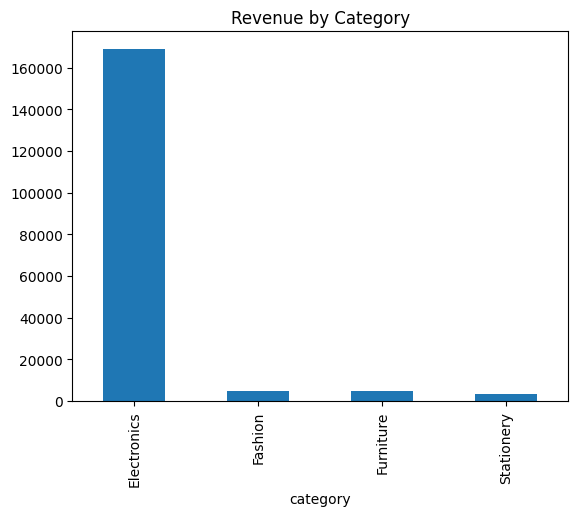

In [13]:
import matplotlib.pyplot as plt
import pandas as pd

# Revenue by category
orders_products = orders_df.join(products_df, "product_id")
orders_products_pd = orders_products.withColumn("revenue", orders_products.quantity * orders_products.price).toPandas()
revenue_category = orders_products_pd.groupby("category")["revenue"].sum()
revenue_category.plot(kind="bar", title="Revenue by Category")
plt.show()



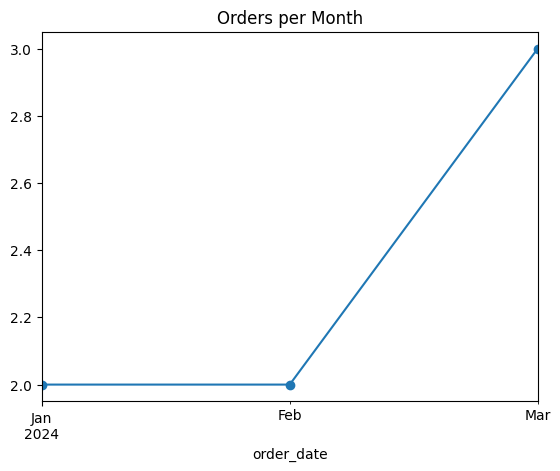

In [12]:
# Orders per month
orders_products_pd["order_date"] = pd.to_datetime(orders_products_pd["order_date"])
orders_per_month = orders_products_pd.groupby(orders_products_pd["order_date"].dt.to_period("M"))["order_id"].count()
orders_per_month.plot(kind="line", marker="o", title="Orders per Month")
plt.show()




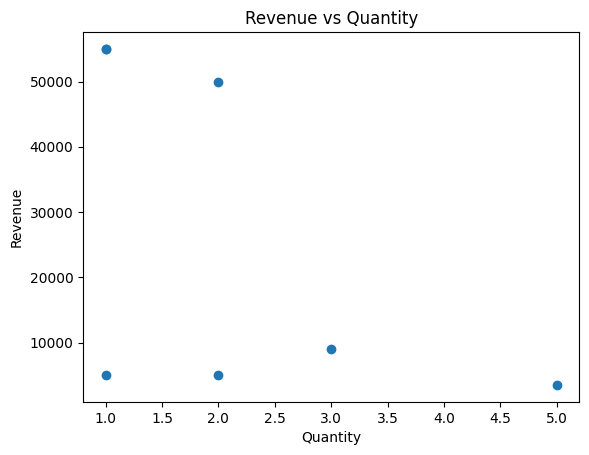

In [11]:
# Revenue vs Quantity
plt.scatter(orders_products_pd["quantity"], orders_products_pd["revenue"])
plt.title("Revenue vs Quantity")
plt.xlabel("Quantity")
plt.ylabel("Revenue")
plt.show()